In [1]:
import pickle
from pathlib import Path
from periodictable import elements
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import exfor_tools

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [3]:
from query_elastic import print_failed_parses, query_elastic_data, reattempt_parse, output_dir

In [4]:
import jitr

In [5]:
proton = (1, 1)
neutron = (1, 0)

In [6]:
target =(148, 62)

In [7]:
(
    (entries_pp, failed_parses_pp),
    (entries_ppr, failed_parses_ppr),
    (entries_nn, failed_parses_nn),
) = query_elastic_data(target)


Parsing (p,p) ...
Found subentry C1397002 with the following columns:
['EN', 'ANG-CM', 'DATA-CM']
Found subentry D0289002 with the following columns:
['EN', 'EN-RSL', 'ERR-DIG', 'DATA-ERR1', 'ERR-1', 'ERR-2', 'ANG-CM', 'DATA-CM', 'ERR-S']
Failed to parse subentry D0289002:
	Ambiguous statistical error labels:
ERR-DIG, DATA-ERR1, ERR-1, ERR-2, ERR-S
Found subentry E0904046 with the following columns:
['EN', 'POL-BM-MIN', 'POL-BM-MAX', 'ANG-CM', 'DATA-CM']
Found subentry F1173002 with the following columns:
['EN', 'ANG-ERR-D', 'ERR-DIG', 'ANG-CM', 'DATA-CM', 'DATA-ERR2']
Failed to parse subentry F1173002:
	Ambiguous statistical error labels:
ERR-DIG, DATA-ERR2

Succesfully parsed 2 entries for (p,p)
Failed to parse 2 entries



Parsing (p,p) ratio ...

Succesfully parsed 0 entries for (p,p) ratio
Failed to parse 0 entries



Parsing (n,n)...

Succesfully parsed 0 entries for (n,n)
Failed to parse 0 entries




# $(p,p)$

## Handle failed parses for $(p,p)$

In [8]:
print_failed_parses(failed_parses=failed_parses_pp)

Entry: D0289
Ambiguous statistical error labels:
ERR-DIG, DATA-ERR1, ERR-1, ERR-2, ERR-S
Entry: F1173
Ambiguous statistical error labels:
ERR-DIG, DATA-ERR2


In [9]:
# from the paper "The errors in the elastic cross sections are statistical, to which should be added
#absolute errors of +2 % for the dete~i~ation of target thickness and kO.25 % for
#each of the errors due to determination of solid angle and calibration of the current
#integrator"
# "The targets + were 95 % pure self-supporting metallic foils of 5 and 15 mg * cm-’ for
#the unpolarized and polarized measurements, respectively. " - DATA-ERR1 is 5% - should that be systematic?

entries_pp["D0289"] = reattempt_parse(
    failed_parses_pp["D0289"],
    parsing_kwargs={
        "statistical_err_labels": ["ERR-S", "ERR-1", "ERR-2", "ERR-DIG"],
        "systematic_err_labels": ["DATA-ERR1"],
    },
)

Found subentry D0289002 with the following columns:
['EN', 'EN-RSL', 'ERR-DIG', 'DATA-ERR1', 'ERR-1', 'ERR-2', 'ANG-CM', 'DATA-CM', 'ERR-S']


In [10]:
entries_pp["F1173"] = reattempt_parse(
    failed_parses_pp["F1173"],
    parsing_kwargs={
        "statistical_err_labels": ["DATA-ERR2", "ERR-DIG"],
    },
)

Found subentry F1173002 with the following columns:
['EN', 'ANG-ERR-D', 'ERR-DIG', 'ANG-CM', 'DATA-CM', 'DATA-ERR2']


## Reject non-useful, discrepant our outlying experiments

# $(p,p)$ ratio

## handle failed parses for $(p,p)$ ratio

In [12]:
print_failed_parses(failed_parses=failed_parses_ppr)

## Reject non-useful, discrepant our outlying experiments

## handle failed parses for $(n,n)$ ratio

In [13]:
print_failed_parses(failed_parses=failed_parses_nn)

# Plotting

## Plot $(p,p)$

In [14]:
measurements_categorized = exfor_tools.categorize_measurements_by_energy(entries_pp)

In [15]:
[[m.Einc for m in l] for l in measurements_categorized]

[[24.5], [49.8], [65.0], [66.5]]

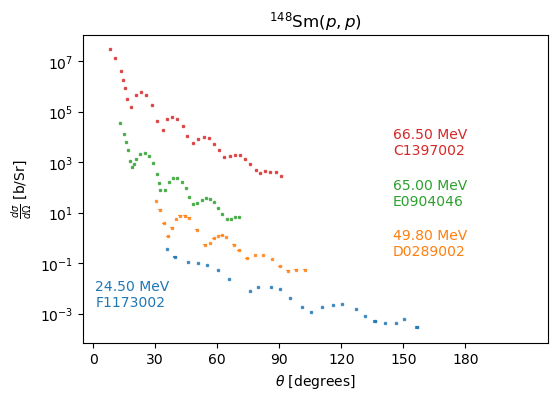

In [17]:
n_per_plot = 10
N = len(measurements_categorized)
num_plots = N // n_per_plot
left_over = N % n_per_plot
if left_over > 0:
    num_plots += 1


fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))
if not isinstance(axes,np.ndarray):
    axes = [axes]
for i in range(num_plots):
    idx0 = i * n_per_plot
    if i == num_plots - 1:
        idxf = N 
    else:
        idxf = (i + 1) * n_per_plot

    exfor_tools.plot_angular_distributions(
        measurements_categorized[idx0:idxf],
        axes[i],
        offsets=100,
        data_symbol=list(entries_pp.values())[0].data_symbol,
        rxn_label=list(entries_pp.values())[0].rxn,
        label_kwargs={
            "label_xloc_deg": None,
            "label_offset_factor": 0.002,
            "label_energy_err": False,
            "label_offset": False,
            "label_incident_energy": True,
            "label_excitation_energy": False,
            "label_exfor": True,
        },
    )
    axes[i].set_xlim([-5, 220])

## plot $(p,p)$ ratio

## Plot $(n,n)$

# Write data to disk

In [18]:
A, Z = target
with open(output_dir / f"{elements[Z]}{A}_diff_xs.pkl", "wb") as f:
    pickle.dump({"n,n": entries_nn, "p,p": { "absolute" :  entries_pp , "ratio" : entries_ppr }}, f)